$\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\Prob}{\mathcal{P}}
\newcommand{\lp}{\left}
\newcommand{\rp}{\right}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}$

In [14]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from itertools import product
from collections import OrderedDict

# Настройка matplotlib-а
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})
# matplotlib.rc('text', usetex=True) 
matplotlib.rc('text', usetex=False)  
# matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

<a name='_toc'></a>
# Содержание
* [1. Код](#code)
    * [1.1 EmpiricalDistribution](#code_empirical)
    * [1.2 Plotters](#code_plotters)
    * [1.3 Bootstrap](#code_bootstrap)
* [2. Эмпирические функции распределения](#empirical)
    * [2.1 Примеры отрисовки](#empirical_examples)
        * [2.1.1 Нормальное распределение](#empirical_norm)
        * [2.1.2 Биномиальное распределение](#empirical_binom)
    * [2.2 Оценка эмпирической функции распределения](#empirical_est)
* [3. Бутстреп](#bootstrap)
    * [Оценки значений $\mean{\boldX_n}$ и $\mean{\boldX_n}e^{-\mean{\boldX_n}}$ для $X \sim \Poisson(\lambda)$](#seminar1_23)

### Некоторое полезные функции<sup>[toc](#_toc)</sup>
* `np.random.choice(X, (N, B), replace=True)`
* `np.random.choice(X, (B, N), replace=True)`
* Ваши эксперименты должны быть воспроизводимы:
    * При использовании метода `rvs` у генераторов из `scipy.stats` не забывайте явно выставлять параметр `random_state`.
    * При использовании `np.random`, явно инициализируйте seed генератора `np.random.seed(seed_value)`.
    * В качестве альтернативы предыдущему пункту можно создать свой генератор через `gen = np.random.RandomState(seed)`. Методы объекта `gen` - это те же методы, что определены в модуле `np.random`. 
* При построении эмпирической функции распределения следует пользоваться функцией `plt.step` (или `ax.step`), с параметром `hich='post'`.
* Параметр `ddof` у `np.std(samples)` и `samples.std()`
* Не использовать константы в коде: вместо 1.96 следует использовать переменную `z_alpha = scipy.stats.norm.ppf(1 - alpha / 2)`

<a name='code'></a>
# 1. Код<sup>[toc](#_toc)</sup>

<a name='code_empirical'></a>
## 1.1 EmpiricalDistribution<sup>[toc](#_toc)</sup>

In [17]:
class EmpiricalDistribution:
    """This class provides empirical distribution functionality. It can be used to
    - estimate empirical cdf and pdf at any points;
    - sample from the empirical distribution;
    - get point masses and cdf arrays for plotting.

    This implementations assumes that
    F(x) = P(X <= x) = Sum_i I[X_i <= x]
    """
    def __init__(self, samples, include=True, seed=None):
        """Initialize empirical distribution.

        Arguments:
        - samples: numpy array, list or tuple of 1D samples
        :param include: bool
        - seed:    random seed for inner generator
        """
        self.set_samples(samples)
        self.set_seed(seed)
        self._include = include  # TODO: setter

    def __len__(self):
        return self.n_samples

    def __str__(self):
        return type(self).__name__

    def set_samples(self, samples):
        """(Re)set samples. Samples are sorted before being stored that takes about O(N logN) operations.
        - samples: numpy array, list or tuple of 1D samples;
        """
        if not isinstance(samples, (list, tuple, np.ndarray)):
            raise TypeError('"samples" must be either np.array, list or tuple.')
        self.n_samples = len(samples)
        self.samples = np.sort(samples)
        self.cdf_data_calculated = False
        self.pdf_data_calculated = False

    def set_seed(self, seed):
        """
        Create an inner generator used to sample data from empirical distribution.
        """
        self.seed = seed
        self.gen = np.random.RandomState(seed)

    def add_sample(self, sample):
        self.add_samples(np.array([sample]))

    def add_samples(self, samples):
        """
        Add additional samples. This operation can be quite costly, since it requires all samples to be sorted,
            that takes about O((n + m) log (n + m)) operations where n is initial number of samples and
            m is the number of samples to add.

        Arguments:
        - samples: numpy array, list or tuple of 1D samples
        """
        self.samples = np.concatenate(self.samples, samples)
        self.samples = np.sort(self.samples)
        self.cdf_data_calculated = False
        self.pdf_data_calculated = False

    def cdf(self, x):
        """
        Returns the CDF value of the empirical distribution at the given point x.

        Arguments:
        - x: number; it is the value to estimate CDF at.

        Returns:
        - F(x): an estimated CDF value.
        """
        if self._include:
            return np.sum(self.samples <= x) / self.n_samples
        return np.sum(self.samples < x) / self.n_samples

    def pdf(self, x):
        """
        Returns the PDF value of the empirical distribution at the given point x.

        Arguments:
        - x: number; it is the value to estimate PDF at.

        Returns:
        - p(x): an estimated PDF value.
        """
        assert False, 'Not defined.'

    def sample(self, size=None, replace=True):
        """Take random uniform samples from inner samples.

        Arguments:
        - size:    the number of samples to return;
        - replace: if True, repeating samples are possible; otherwise, each sample can appear only once,
                   but in this case one could not request more samples that empirical distribution is built upon.

        Returns:
        - numpy array if shape (size,) containing size samples from the stored ones.
        """
        return self.gen.random.choice(self.samples, size=size, replace=replace)

    def get_cdf_data(self, append_borders=0.1):
        """Get data required to plot CDF. This function correctly handles repeating samples (which are typical
        in case of discrete distributions). This function caches the calculated data, so that consecutive calls
        do not require additional computations. This is true until new samples are added
        to the empirical distribution.

        Arguments:
        - append_borders: nonegative number.
            If append_borders > 0, adds border points x_left and x_right such that F(x_left) = 0, F(x_right) = 1.
            It is required for appropriate plotting since otherwise the plots do not show levels 0 and 1 of CDF.
            The values of x_left and x_right are found as follows:
                x_left = min(samples) - append_borders * (max(samples) - min(samples))
                x_right = max(samples) +  append_borders * (max(samples) - min(samples))
            If append_boreders = 0, then does not add these additional points. In this case the lengths of
            returned arrays are equal to the number of samples stored inside.

        Returns shape (points, cumulatives):
        - points: numpy array which contains stored samples (and border points if append_borders > 0)
            in ascending order.
        - cumulatives: numpy array which contains CDF values for the returned points.
            Attention! cumulatives[i] contains CDF value between points points[i] and points[i + 1].
            Thus, if CDF is plotted by means of plt.step(...), then "which='post'" must be used to plot
            it correctly.
        """
        assert append_borders >= 0
        if self.cdf_data_calculated:
            points, cumulatives = self.points, self.cumulatives
        else:
            points, masses = self.get_pdf_data()
            cumulatives = np.array(masses)
            for i in range(1, len(cumulatives)):
                cumulatives[i] += cumulatives[i - 1]
            assert abs(cumulatives[-1] - 1) < 1e-8
            self.cumulatives = cumulatives
            self.cdf_data_calculated = True
        if append_borders > 0:
            x_width = points[-1] - points[0]
            x_low = points[0] - append_borders * x_width
            x_high = points[-1] + append_borders * x_width
            points = np.concatenate([[x_low], points, [x_high]])
            cumulatives = np.concatenate([[0.0], cumulatives, [1.0]])
        return points, cumulatives

    def get_pdf_data(self):
        """
        Get data required to plot PDF. This function correctly handles repeating samples (which are typical
        in case of discrete distributions). This function caches the calculated data, so that consecutive calls
        do not require additional computations. This is true until new samples are added
        to the empirical distribution.
        """
        if self.pdf_data_calculated:
            return self.points, self.masses
        prev_x = -np.inf
        x = []
        y = []
        for curr_x in self.samples:
            if curr_x == prev_x:
                y[-1] += 1
            else:
                y.append(1)
                x.append(curr_x)
                prev_x = curr_x
        self.points = np.array(x)
        self.masses = np.array(y) / self.n_samples
        self.pdf_data_calculated = True
        return self.points, self.masses

<a name='code_plotters'></a>
## 1.2 Plotters<sup>[toc](#_toc)</sup>

In [18]:
def plot_empirical_pdf(x, y, ax, grid=True, color='k', border_ext=0.05,
                       xlim=None, ylim=None,
                       xlabel=None, ylabel=None, title=None, label=None,
                       arrowwidth=None, headwidth=3, headlength=5,
                       verbose=False):
    """
    Plot PDF of empirical (discrete) distribution.
    - ax:          This is the axis to plot data in.
    - grid:        If True, grid is plotted; default is True.
    - color:       Color for plotting arrows (delta-functions); default is black ('k').
    - border_ext:  Vertical and horizontal ranges will be expaned by (bordered_ext * 100)% of data ranges; 
        this parameter is not taken into account for axis X or Y if xlim or ylim are passed, respectively.
    - xlim:        Tuple (xmin, xmax); eliminates effect of border_ext.
    - ylim:        Tuple (ymin, ymax); eliminates effect of border_ext.
    - xlabel:      Lable for axis X.
    - ylabel:      Label for axis Y.
    - title:       title.
    - label:       Label to be shown in legend.
    - arrowwidth:  The absolute width of arrows used to represent delta functions of discrete PDF.
    - headwidth:   The relative width of arrows' heads; the default value is 3 absolute arrow widths.
    - headlength: 
    - verbose:     If True, prints debug information; default is False.
    """
    assert len(x) == len(y)
    x_width = np.max(x) - np.min(x) # ширина по оси X
    y_width = np.max(y)             # ширина по оси Y (минимальное значение - 0)
    if verbose:
        print('plot_point_masses: x_width = {}, y_width = {}, border_ext = {}'.format(x_width, y_width, border_ext))
    if arrowwidth is None:
        arrowwidth = 0.005 * y_width
    else:
        arrowwidth = arrowwidth * y_width
    X = x
    Y = np.zeros_like(X)
    U = np.zeros_like(X)
    V = y
    ax.quiver(X, Y, U, V, units='y', scale=1, scale_units='y', zorder=2,
              width=arrowwidth, headwidth=headwidth, headlength=headlength, color=color, label=label)
    
    x_low  = np.min(x) - border_ext * x_width
    x_high = np.max(x) + border_ext * x_width
    y_low = 0
    y_high = np.max(y) + border_ext * y_width
    # GRID
    if grid: ax.grid(which='both', linestyle='--', alpha=0.5)
    # LIMITS
    if xlim is None: xlim = (x_low, x_high)
    if ylim is None: ylim = (y_low, y_high)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if verbose:
        print('plot_point_masses: xlim is set to ({:.2f}, {:.2f})'.format(xlim[0], xlim[1]))
        print('plot_point_masses: ylim is set to ({:.2f}, {:.2f})'.format(ylim[0], ylim[1]))
    # LABELS
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title is not None:  ax.set_title(title)
    return ax


def plot_empirical_cdf(points, cumulatives, ax, grid=True, color='b', border_ext=0.05, 
                       xlim=None, ylim=None, xlabel=None, ylabel=None, title=None, label=None,
                       verbose=False):
    """
    Plot CDF of empirical (discrete) distribution.
    - points:      Coordinates of point masses
    - cumulatives: CDF values.
        It is assumed, that cumulatives[i] gives CDF value at intervals [points[i], points[i + 1]]
    - ax:          This is the axis to plot data in.
    - grid:        If True, grid is plotted; default is True.
    - color:       Color for plotting CDF; default is blue ('b').
    - border_ext:  Vertical and horizontal ranges will be expaned by (bordered_ext * 100)% of data ranges; 
        this parameter is not taken into account for axis X or Y if xlim or ylim are passed, respectively.
    - xlim:        Tuple (xmin, xmax); eliminates effect of border_ext.
    - ylim:        Tuple (ymin, ymax); eliminates effect of border_ext.
    - xlabel:      Lable for axis X.
    - ylabel:      Label for axis Y.
    - title:       title.
    - label:       Label to be shown in legend.
    - verbose:     If True, prints debug information; default is False.
    """
    y_low = 0; y_high = 1.0 + border_ext
    
    x_min = points[0]
    x_max = points[-1]
    x_width = x_max - x_min
    x_low  = x_min - border_ext * x_width
    x_high = x_max + border_ext * x_width

    ax.step(points, cumulatives, where='post', label=label, color=color, zorder=2)
    # GRID
    if grid: ax.grid(which='both', linestyle='--', alpha=0.5)
    # LIMITS
    if xlim is None: xlim = (x_low, x_high)
    if ylim is None: ylim = (y_low, y_high)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if verbose:
        print('plot_point_masses: xlim is set to ({:.2f}, {:.2f})'.format(xlim[0], xlim[1]))
        print('plot_point_masses: ylim is set to ({:.2f}, {:.2f})'.format(ylim[0], ylim[1]))
    # LABELS
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title  is not None:
        ax.set_title(title)
    return ax 

<a name='code_boostrap'></a>
## 1.3 Bootstrap<sup>[toc](#_toc)</sup>

In [19]:
class Bootstrap:
    """This class provides bootstrap functionality:
    - it can be used to generate bootstrap samples
    - it can be used to estimate three types of bootstrap confidence intervals
    """
    def __init__(self, samples, functional=None, seed=1):
        """
        - samples:    Numpy array, list or tuple of samples.
        - seed:       Nonnegative integer; seed to initialize inner generator used for subsampling.
        - functional: A callable entity which accepts bootstrap samples and finds required statistic.
        """
        self.samples = np.array(samples)
        self.set_seed(seed)
        self.functional = functional
        self.statistics = []
        if self.functional is not None:
            self.func_init = self.functional(self.samples)

    def set_seed(self, seed):
        """Initializes inner generator with provided seed.
        """
        self.seed = seed
        self.gen = np.random.RandomState(seed)

    def generate(self, size=None, return_samples=True):
        """
        Arguments:
        - size:            Number of samples to bootstrap; by default it is the number of stored samples.
        - return_samples:  If True, function returns generated samples; otherwise returns nothing.

        Returns generated samples in numpy array of shape (size, ) if return_samples is True.
        Otherwise returns None.
        """
        if size is None:
            size = len(self.samples)
        subsamples = self.gen.choice(self.samples, size=size)
        if self.functional is not None:
            self.statistics.append(self.functional(subsamples))
        if return_samples:
            return subsamples

    def get_statistics(self):
        """
        Returns all calculated estimates in a list. It makes sense only if "functional" passed to the constructor is not None.
        """
        return list(self.statistics)

    def get_init_estimate(self):
        """
        Returns the value of statistics calculated on initial samples passed to the constructor.
        """
        return self.func_init

    def get_interval(self, alpha=0.05, conf_type='normal'):
        """
        Returns 1 - alpha confidence interval of type "normal".

        Arguments:
        - alpha:     (1-alpha) confidence intervals.
        - conf_type: "normal", "centra", "percentile".
        """
        if conf_type == 'normal':
            return self.get_normal_interval(alpha)
        if conf_type == 'central':
            return self.get_central_interval(alpha)
        if conf_type == 'percentile':
            return self.get_percentile_interval(alpha)
        assert False

    def get_normal_interval(self, alpha):
        # Нормальная оценка
        z = abs(stats.norm().ppf(alpha / 2))
        func_std = np.std(self.statistics)
        left, right = self.func_init - z * func_std, self.func_init + z * func_std
        return (left, right)

    def get_central_interval(self, alpha):
        # Центральный интервал
        left = 2 * self.func_init - np.percentile(self.statistics, 100 * (1 - alpha / 2))
        right = 2 * self.func_init - np.percentile(self.statistics, 100 * (alpha / 2))
        return (left, right)

    def get_percentile_interval(self, alpha):
        # Интервал на основе процентилей
        left = np.percentile(self.statistics, 100 * alpha / 2)
        right = np.percentile(self.statistics, 100 * (1 - alpha / 2))
        return (left, right)

In [20]:
def get_all_bootstrap_intervals(bootstrap, alpha):
    """
    Given Bootstrap object this function aggregates all bootstrap confendence intervals into a dict object.
    """
    data = OrderedDict()
    data['alpha'] = alpha
    data['estimate'] = bootstrap.get_init_estimate()
    data['normal'] = bootstrap.get_normal_interval(alpha)
    data['central'] = bootstrap.get_central_interval(alpha)
    data['percentile'] = bootstrap.get_percentile_interval(alpha)
    return data

def plot_confidence_intervals(data, ax, grid=True, legend=True, ylabel=None, title=None):
    """
    This function plots confidence intervals based on the provided data.
    
    Arguments:
    - data:   (dict) Dictionary must contain 'alpha' and 'estimate' values where:
      - alpha: is the parameter of the confidence intervals to plot;
      - estimate: is the estimated value of the parameter of interest.
    - ax:     (Axis) 
    - grid:   (bool)
    - legend: (bool)
    - ylabel: (str)
    - title:  (str)
    
    Returns the axis object passed to the function.
    """
    n = 1
    alpha = data['alpha']
    if 'true' in data:
        low, upp = data['true']
        if 'true_estimate' in data:
            estimate = data['true_estimate']
        else:
            estimate = data['estimate']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='k', elinewidth=2, capsize=10, 
                    capthick=1, label='True {:.1f}\%-interval'.format(100 * (1 - alpha)))
        n += 1
        
    estimate = data['estimate']
    if 'normal' in data:
        low, upp = data['normal']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='g', elinewidth=2, capsize=10, 
                    capthick=1, label='Normal {:.1f}\%-interval'.format(100 * (1 - alpha)))
        n += 1
    if 'central' in data:
        low, upp = data['central']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='b', elinewidth=2, capsize=10, 
                    capthick=1, label='Central {:.1f}\%-interval'.format(100 * (1 - alpha)))
        n += 1
    if 'percentile' in data:
        low, upp = data['percentile']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='m', elinewidth=2, capsize=10, 
                    capthick=1, label='Percentile {:.1f}\%-interval'.format(100 * (1 - alpha)))
        n += 1
    # Горизонтальные линии
    if 'true' in data:
        low, upp = data['true']
        ax.plot([1, n - 1], [low, low], color='k', linestyle='--')
        ax.plot([1, n - 1], [upp, upp], color='k', linestyle='--')
        
    ax.set_xlim([0, n + 3])
    ax.grid(which='both', linestyle='--', alpha=0.5)
    ax.legend(loc='center right', numpoints=1, fontsize=20)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    return ax

<a name='empirical'></a>
# 2. Эмпирические функция и плотность распределения<sup>[toc](#_toc)</sup>

<a name='empirical_examples'></a>
## 2.1 Примеры отрисовки<sup>[toc](#_toc)</sup>

<a name='empirical_norm'></a>
### 2.1.1 Нормальное распределение<sup>[toc](#_toc)</sup>

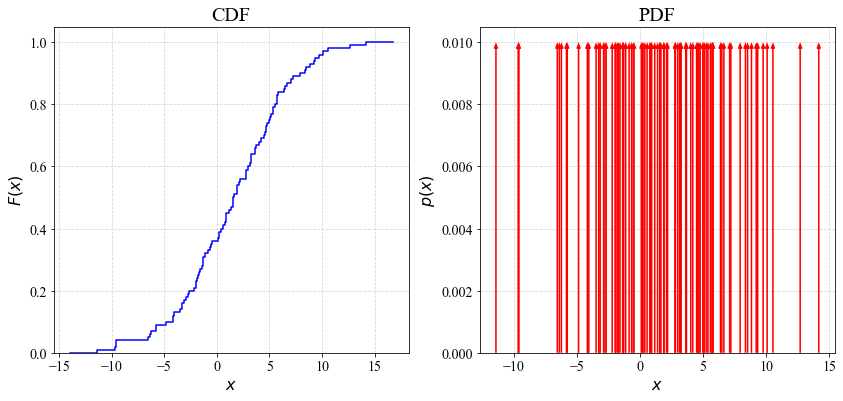

In [21]:
gen = scipy.stats.norm(loc=1, scale=5)
samples = gen.rvs(size=100, random_state=6)
edist = EmpiricalDistribution(samples, seed=0)

figsize = (14, 6)
f, axarr = plt.subplots(1, 2, figsize=figsize)

points, cumulatives = edist.get_cdf_data(append_borders=0.1)
plot_empirical_cdf(points, cumulatives, axarr[0], xlabel='$x$', ylabel='$F(x)$', title='CDF')

points, masses = edist.get_pdf_data()
plot_empirical_pdf(points, masses, axarr[1], xlabel='$x$', ylabel='$p(x)$', title='PDF', 
                   arrowwidth=None, headwidth=3, headlength=4, color='r')

<a name='empirical_binom'></a>
### 2.1.2 Биномиальное распределение<sup>[toc](#_toc)</sup>

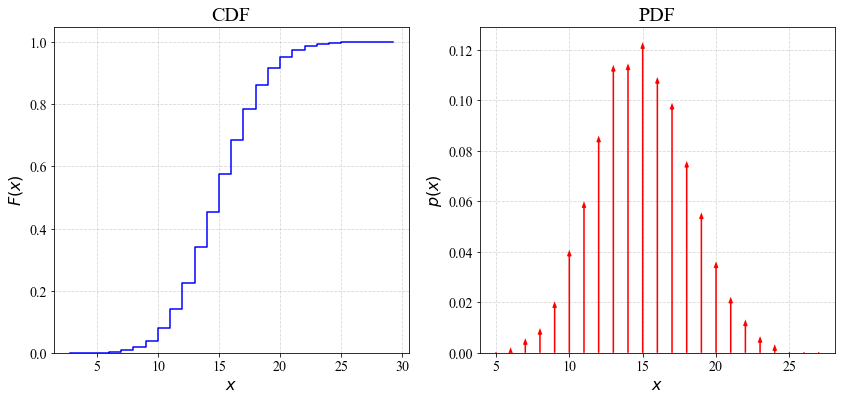

In [24]:
gen = scipy.stats.binom(n=50, p=0.3)
samples = gen.rvs(size=5000, random_state=7)
edist = EmpiricalDistribution(samples, seed=0)

figsize = (14, 6)
f, axarr = plt.subplots(1, 2, figsize=figsize)

points, cumulatives = edist.get_cdf_data(append_borders=0.1)
plot_empirical_cdf(points, cumulatives, axarr[0], xlabel='$x$', ylabel='$F(x)$', title='CDF')

points, masses = edist.get_pdf_data()
plot_empirical_pdf(points, masses, axarr[1], xlabel='$x$', ylabel='$p(x)$', title='PDF', 
                   arrowwidth=None, headwidth=3, headlength=4, color='r')

<a name='empirical_est'></a>
## 2.2 Оценка эмпирической функции распределения<sup>[toc](#_toc)</sup>

In [25]:
class Distribution:
    def cdf(self, x):
        raise NotImplementedError("Must be defined in derived classes.")

    def pdf(self, x):
        raise NotImplementedError("Must be defined in dervied classes.")


class TriangularDistribution(Distribution):
    def __init__(self, left=0, right=2):
        self.left = left
        self.right = right
        self.mid = (left + right) / 2
        self.amplitude = 0.5 * (right - left)
        self.area = self.amplitude ** 2

    def cdf(self, x):
        if x < self.left:
            return 0.0
        if x < self.mid:
            return (0.5 * x ** 2 - self.left * x) / self.area
        if x < self.right:
            return 1 - 0.5 * (self.right - x) ** 2 / self.area
        return 1.0

    def pdf(self, x):
        if x < self.left:
            return 0.0
        if x < self.mid:
            return (x - self.left) / self.area
        if x < self.right:
            return (self.right - x) / self.area
        return 0.0

In [26]:
left = 0
right = 2
mid = 0.5 * (left + right)
true_dist = TriangularDistribution(left, right)

np.random.seed(7)
n_samples = 100 # размер выборки
samples = np.sort(np.random.uniform(left, mid, size=n_samples) + np.random.uniform(left, mid, size=n_samples))

# Бутстреп
bootstrap_size = 1000
all_bootstrap_samples = np.random.choice(samples, (bootstrap_size, n_samples), replace=True)

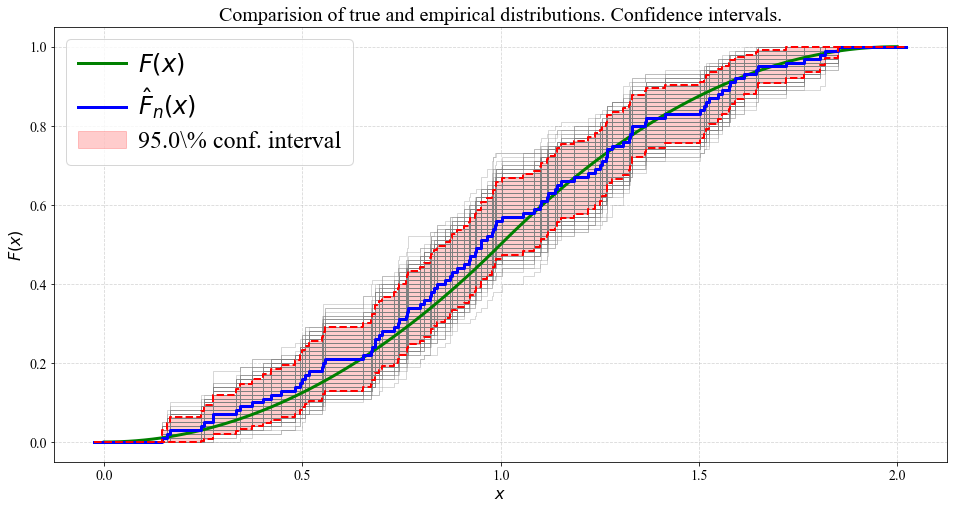

In [27]:
plt.figure(figsize = (16, 8))
matplotlib.rcParams['legend.handletextpad'] = 0.5
n_plot_points = 100
append_borders = 0.1
plot_norm_conf = True
plot_perc_conf = False


base_kwargs = {'zorder': 3}

# Истинное распределение
true_kwargs = dict(base_kwargs)
true_kwargs['color'] = 'g'
true_kwargs['linewidth'] = 3
true_kwargs['label'] = '$F(x)$'

# Бутстрепные распределения
boot_kwargs = dict(base_kwargs)
boot_kwargs['color'] = 'gray'
boot_kwargs['alpha'] = 0.3
boot_kwargs['where'] = 'post'
boot_kwargs['linewidth'] = 1

# Эмпирическое распределение
empr_kwargs = dict(base_kwargs)
empr_kwargs['color'] = 'b'
empr_kwargs['where'] = 'post'
empr_kwargs['linewidth'] = 3
empr_kwargs['label'] = '$\hat{F}_n(x)$'

# Доверительный интервал
alpha = 0.05
norm_conf_kwargs = dict(base_kwargs)
norm_conf_kwargs['color'] = 'r'
norm_conf_kwargs['linewidth'] = 2
norm_conf_kwargs['linestyle'] = '--'
norm_conf_kwargs['where'] = 'post'

perc_conf_kwargs = dict(base_kwargs)
cmap = plt.get_cmap('jet')
perc_conf_kwargs['color'] = cmap(0.1)
perc_conf_kwargs['linewidth'] = 2
perc_conf_kwargs['linestyle'] = '-.'
perc_conf_kwargs['where'] = 'post'

fill_kwargs = {}
fill_kwargs['color'] = 'r'
fill_kwargs['step'] = 'post'
fill_kwargs['alpha'] = 0.2
fill_kwargs['label'] = '{:.1f}\% conf. interval'.format((1 - alpha) * 100)
fill_kwargs['zorder'] = 2

# Построение множества бутстрепных функций распределений
for bootstrap_samples in all_bootstrap_samples:
    edist = EmpiricalDistribution(bootstrap_samples)
    points, cumulatives = edist.get_cdf_data(append_borders=append_borders)
    plt.step(points, cumulatives, **boot_kwargs)

# Построение истинного распределения
x_values = np.linspace(left, right, n_plot_points)
plt.plot(x_values, list(map(true_dist.cdf, x_values)), **true_kwargs)

# Построение эмпирического распределения и его доверительных интервалов
edist = EmpiricalDistribution(samples)
points, cumulatives = edist.get_cdf_data(append_borders=append_borders)

plt.step(points, cumulatives, **empr_kwargs)

# Нормальные доверительные интервалы
if plot_norm_conf:
    z_alpha = scipy.stats.norm.ppf(1 - alpha / 2)
    std = np.sqrt(np.maximum(cumulatives * (1 - cumulatives) / n_samples, 0.0))
    norm_upper_bound = np.minimum(cumulatives + z_alpha * std, 1)
    norm_lower_bound = np.maximum(cumulatives - z_alpha * std, 0)
    plt.step(points, norm_upper_bound, **norm_conf_kwargs)
    plt.step(points, norm_lower_bound, **norm_conf_kwargs)
    plt.fill_between(points, norm_lower_bound, norm_upper_bound, **fill_kwargs)

# Процентильные доверительные интервалы
if plot_perc_conf:
    perc_upper_bound = []
    perc_lower_bound = []
    for sample, cumulative in zip(samples, cumulatives):
        p = np.mean(samples <= sample)
        left  = scipy.stats.binom.ppf(alpha / 2, n=n_samples, p=p) / n_samples
        right = scipy.stats.binom.ppf(1 - alpha / 2, n=n_samples, p=p) / n_samples
        perc_lower_bound.append(max(left, 0.0))
        perc_upper_bound.append(min(right, 1.0))
    plt.step(samples, perc_upper_bound, **perc_conf_kwargs)
    plt.step(samples, perc_lower_bound, **perc_conf_kwargs)

plt.legend(loc='upper left', fontsize=24)
plt.xlabel('$x$'); plt.ylabel('$F(x)$')
plt.title('Comparision of true and empirical distributions. Confidence intervals.')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.show()

<a name='bootstrap'></a>
# 3. Бутстреп. Доверительные интервалы<sup>[toc](#_toc)</sup>

<a name='seminar1_23'></a>
## Оценки значений $\mean{\boldX_n}$ и $\mean{\boldX_n}e^{-\mean{\boldX_n}}$ для $X \sim \Poisson(\lambda)$<sup>[toc](#_toc)</sup>

In [28]:
mu = 0.25
random_state = 1
n_samples = 1000
alpha = 0.05

gen = scipy.stats.poisson(mu=mu)
samples = gen.rvs(size=n_samples, random_state=random_state)

true_theta_value = mu * np.exp(-mu)
def theta_function(samples):
    mean = np.mean(samples)
    return mean * np.exp(-mean)
# theta_str = r'$\overline{\boldsymbol{X}_n}e^{-\overline{\boldsymbol{X}_n}}$'
theta_str = '<{X}_n>e^(-<{X}_n>)'

"""true_theta_value = np.exp(mu)
def theta_function(samples):
    return np.exp(np.mean(samples))
theta_str = r'$e^{\overline{\boldsymbol{X}_n}}$'"""

bootstrap = Bootstrap(samples, theta_function, seed=1)
bootstrap_size = 5000
for i in range(bootstrap_size):
    bootstrap.generate(return_samples=False)

Теоретическое значение статистики: 0.19470019576785122
Оценка статистики на основе начальной выборки: 0.20104332001953568
Бутстрепная оценка статистики: 0.2009856182006933
Нормальный доверительный интервал:  (0.18351534804355746, 0.2185712919955139)
Центральный доверительный интервал: (0.18403022753485107, 0.2193439114633045)
Квантильный доверительный интервал: (0.18274272857576684, 0.21805641250422028)
Истинный доверительный интервал:    (0.1759274562756442, 0.21216296226993847)


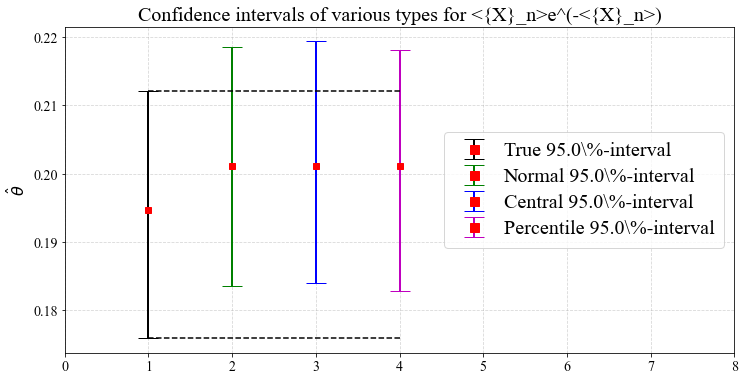

In [29]:
print('Теоретическое значение статистики:', true_theta_value)
print('Оценка статистики на основе начальной выборки:', theta_function(samples))
print('Бутстрепная оценка статистики:',      np.mean(bootstrap.get_statistics()))
print('Нормальный доверительный интервал: ', bootstrap.get_normal_interval(alpha))
print('Центральный доверительный интервал:', bootstrap.get_central_interval(alpha))
print('Квантильный доверительный интервал:', bootstrap.get_percentile_interval(alpha))

theta_gen = scipy.stats.poisson(mu=n_samples * mu)
left, right = theta_gen.interval(1 - alpha)
true_theta_left = theta_function(left / n_samples)
true_theta_right = theta_function(right / n_samples)
print('Истинный доверительный интервал:   ', (true_theta_left, true_theta_right))

f, ax = plt.subplots(1, 1, figsize=(12, 6))

conf_data = get_all_bootstrap_intervals(bootstrap, alpha)
conf_data['true'] = (true_theta_left, true_theta_right)
conf_data['true_estimate'] = true_theta_value
plot_confidence_intervals(conf_data, ax, ylabel=r'$\hat{\theta}$',
                          title=r'Confidence intervals of various types for {}'.format(theta_str))